In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn                    import metrics
from sklearn.linear_model       import LogisticRegression, LinearRegression, RidgeClassifier, Lasso, SGDClassifier
from sklearn.neural_network     import MLPClassifier
from sklearn                    import svm
from sklearn.preprocessing      import StandardScaler, OrdinalEncoder, OneHotEncoder, PowerTransformer, QuantileTransformer
from sklearn.cluster            import KMeans
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.naive_bayes        import GaussianNB, MultinomialNB
from sklearn.model_selection    import cross_val_score, ShuffleSplit, GridSearchCV, train_test_split, StratifiedKFold, cross_val_predict
from sklearn                    import pipeline
from sklearn.tree               import DecisionTreeClassifier
from sklearn.experimental       import enable_hist_gradient_boosting # for HistGradientBoostingClassifier
from sklearn.ensemble           import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost                    import XGBClassifier
#from lightgbm                   import LGBMClassifier
from catboost                   import CatBoostClassifier
from sklearn                    import impute
from sklearn                    import compose
import datetime as dt
import time
import os


In [ ]:
df = pd.read_csv("dataset_halfSecondWindow.csv", index_col='id')

train_users = df[(df['user'] != "U12") & (df['user'] != "U9") & (df['user'] != "U2")]
test_user = df[(df['user'] == "U12")]# | (df['user'] == "U9")| (df['user'] == "U2")]


print(train_users['target'].unique())
print(test_user['target'].unique())
print(f"TRAIN USERS {len(train_users)}")
print(f"TEST USERS {len(test_user)}")

['Bus' 'Car' 'Still' 'Train' 'Walking']
['Bus' 'Car' 'Still' 'Train' 'Walking']
TRAIN USERS 49782
TEST USERS 9081


In [ ]:
tree_classifiers = {
        "Decision Tree": DecisionTreeClassifier(),
        "Extra Trees":ExtraTreesClassifier(),
        "Random Forest":RandomForestClassifier(),
        #"AdaBoost":AdaBoostClassifier(),
        #"Skl GBM":GradientBoostingClassifier(),
        "Skl HistGBM":HistGradientBoostingClassifier(),
        #"XGBoost":XGBClassifier(use_label_encoder=False),
        #"LightGBM":LGBMClassifier(),
        "CatBoost":CatBoostClassifier(verbose=0)
        }
        

In [ ]:
cat_vars1 = ['user']

num_vars_nan0 = [
            "time",
            # "activityrecognition#0",
            "activityrecognition#1",
            "android.sensor.accelerometer#mean",
            "android.sensor.accelerometer#min",
            "android.sensor.accelerometer#max",
            "android.sensor.accelerometer#std",

            # "android.sensor.game_rotation_vector#mean",
            # "android.sensor.game_rotation_vector#min",
            # "android.sensor.game_rotation_vector#max",
            # "android.sensor.game_rotation_vector#std",

            # "android.sensor.gravity#mean",
            # "android.sensor.gravity#min",
            # "android.sensor.gravity#max",
            # "android.sensor.gravity#std",

            "android.sensor.gyroscope#mean",
            "android.sensor.gyroscope#min",
            "android.sensor.gyroscope#max",
            "android.sensor.gyroscope#std",

            "android.sensor.gyroscope_uncalibrated#mean",
            "android.sensor.gyroscope_uncalibrated#min",
            "android.sensor.gyroscope_uncalibrated#max",
            "android.sensor.gyroscope_uncalibrated#std",

            # "android.sensor.light#mean",
            # "android.sensor.light#min",
            # "android.sensor.light#max",
            # "android.sensor.light#std",

            "android.sensor.linear_acceleration#mean",
            "android.sensor.linear_acceleration#min",
            "android.sensor.linear_acceleration#max",
            "android.sensor.linear_acceleration#std",

            # "android.sensor.magnetic_field#mean",
            # "android.sensor.magnetic_field#min",
            # "android.sensor.magnetic_field#max",
            # "android.sensor.magnetic_field#std",

            # "android.sensor.magnetic_field_uncalibrated#mean",
            # "android.sensor.magnetic_field_uncalibrated#min",
            # "android.sensor.magnetic_field_uncalibrated#max",
            # "android.sensor.magnetic_field_uncalibrated#std",

            # "android.sensor.orientation#mean",
            # "android.sensor.orientation#min",
            # "android.sensor.orientation#max",
            # "android.sensor.orientation#std",

            "android.sensor.pressure#mean",
            "android.sensor.pressure#min",
            "android.sensor.pressure#max",
            "android.sensor.pressure#std",

            # "android.sensor.proximity#mean",
            # "android.sensor.proximity#min",
            # "android.sensor.proximity#max",
            # "android.sensor.proximity#std",

            # "android.sensor.rotation_vector#mean",
            # "android.sensor.rotation_vector#min",
            # "android.sensor.rotation_vector#max",
            # "android.sensor.rotation_vector#std",

            "android.sensor.step_counter#mean",
            "android.sensor.step_counter#min",
            "android.sensor.step_counter#max",
            "android.sensor.step_counter#std",

            # "sound#mean",
            # "sound#min",
            # "sound#max",
            # "sound#std",
            
            "speed#mean",
            "speed#min",
            "speed#max",
            "speed#std",
            
            #"target",
            #"user"
            ]


In [ ]:
x_train = train_users[cat_vars1 + num_vars_nan0]
x_val = test_user[cat_vars1 + num_vars_nan0]
y_train = train_users['target'].map({"Bus":1, "Car":1, "Still": 2, "Train":3, "Walking": 4})
y_val = test_user['target'].map({"Bus":1, "Car":1, "Still": 2, "Train":3, "Walking": 4})

In [ ]:
cat_pipe = pipeline.Pipeline(steps=[
            ("OneHot", OrdinalEncoder(handle_unknown='mean'))
])

num_pipe_nan0 = pipeline.Pipeline(steps=[
            ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
            #('Scaler',StandardScaler()),
])
num_pipe_nanM = pipeline.Pipeline(steps=[
            ('imputer', impute.SimpleImputer(strategy="mean")),
            #('Scaler',StandardScaler()),
])
main_pipe = compose.ColumnTransformer(transformers=[
            #('cats', cat_pipe, cat_vars1),
            ('nums0', num_pipe_nan0, num_vars_nan0)],
            #('numsM', num_pipe_nanM, num_vars_nanM)],
            remainder='drop')

all_pipes = {model_name: pipeline.make_pipeline(main_pipe, model) for model_name, model in tree_classifiers.items()}

In [ ]:
results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [], 'Time': []})
for model_name, model in all_pipes.items():
    print(f"Working on: {model_name}")
    print(model)
    start_time = time.time()
    model.fit(x_train, y_train)
    pred = model.predict(x_val)
    end_time = time.time() - start_time

    results = results.append({"Model":    model_name,
                              "Accuracy": metrics.accuracy_score(y_val, pred)*100,
                              "Bal Acc.": metrics.balanced_accuracy_score(y_val, pred)*100,
                              "Time":     end_time},
                              ignore_index=True)
    print(results)


Working on: Decision Tree
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('nums0',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['time',
                                                   'activityrecognition#1',
                                                   'android.sensor.accelerometer#mean',
                                                   'android.sensor.accelerometer#min',
                                                   'android.sensor.accelerometer#max',
                                                   'android.sensor.accelerometer#std',
                                                   'android.sensor.gyros...
                                      

In [ ]:
pred = pd.DataFrame(data=pred, columns=['Predicions'])
time = pd.DataFrame(data=x_val.time.values, columns=['time'])

In [ ]:
a = pd.DataFrame([1,2,2,3,10])

In [ ]:
a[0].value_counts(normalize=1)

2     0.4
10    0.2
1     0.2
3     0.2
Name: 0, dtype: float64

In [ ]:
frames = [pred, time]
my_data = pd.concat(frames,axis=1, ignore_index=True, sort=False)
my_data.columns = ['Pred','Time']
#"Bus":1, "Car":1, "Still": 2, "Train":3, "Walking": 4
my_data['MET'] = my_data.Pred.map({1:1, 2:1, 3:1, 4:3})  # MET Still:1, Walking:3, Bus,Car,Train:1
my_data

,Pred,Time,MET
0,4,3.0,3
1,4,4.0,3
2,4,5.0,3
3,4,6.0,3
4,4,7.0,3
...,...,...,...
9076,1,299.0,1
9077,1,284.0,1
9078,4,107.0,3
9079,4,137.0,3


In [ ]:
my_data.where(my_data.Time==44).dropna(axis=0) #time repeats


,Pred,Time,MET
41,1.0,44.0,1.0
199,1.0,44.0,1.0
406,1.0,44.0,1.0
873,1.0,44.0,1.0
1159,1.0,44.0,1.0
2317,1.0,44.0,1.0
2807,1.0,44.0,1.0
3137,1.0,44.0,1.0
3645,2.0,44.0,1.0
3704,2.0,44.0,1.0


In [ ]:
time.value_counts(normalize=1)

time  
44.0      0.003193
98.0      0.002533
6.0       0.002533
69.0      0.002533
19.0      0.002533
            ...   
2008.0    0.000110
2007.0    0.000110
2005.0    0.000110
2004.0    0.000110
5727.0    0.000110
Length: 2485, dtype: float64

In [ ]:
#MET=1 if sitting or in transportation vehicle
def cal_burned(MET=1,weight=80,time=1/120): #time is set to half second->apply to column
    #weight in kg, time in minutes
    return time*3.5*MET*weight/200


In [ ]:
my_data['Calories'] = my_data.MET.apply(cal_burned)

In [ ]:
cal_burned(3) #MEF = 3

0.035

In [ ]:
my_data.Calories = my_data.Calories.expanding(min_periods=1).sum()

In [ ]:
my_data.Calories

0         0.035000
1         0.070000
2         0.105000
3         0.140000
4         0.175000
           ...    
9076    134.015000
9077    134.026667
9078    134.061667
9079    134.096667
9080    134.131667
Name: Calories, Length: 9081, dtype: float64

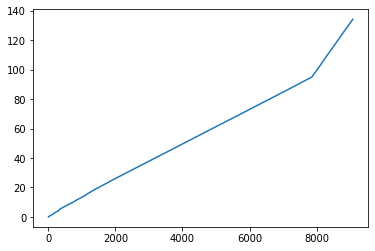

In [ ]:
plt.plot(my_data.Calories)

In [ ]:
my_data.head(120)

,Pred,Time,MET,Calories
0,4,3.0,3,0.035000
1,4,4.0,3,0.070000
2,4,5.0,3,0.105000
3,4,6.0,3,0.140000
4,4,7.0,3,0.175000
...,...,...,...,...
115,1,118.0,1,1.610000
116,1,119.0,1,1.621667
117,1,120.0,1,1.633333
118,1,121.0,1,1.645000


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dd66c499-8cd9-44d2-87d5-ecc9c3ddd387' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>